# ML Models with feature selection using k-means

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style = 'whitegrid', font_scale = 1.3)

In [2]:
sys.path.append('..')
from modules.plotting_metrics import PlotMetric

#### Loading data

In [3]:
# Read the MDS resutls to be used for clustering
import pickle
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
with open(path_mds_obj, 'rb') as f:
    mds_pisani_402 = pickle.load(f)

In [4]:
# Helper functions, load after having mds_pisani in memory
%run ./helper_functions_S6.ipynb

In [5]:
# Dictionary of docking results
# notebook helper_functions does the trick
scores_dic = get_docking_scores_dict()

### Get the conformations with the best AUC in each dataset (docking scores using Vinardo)

In [6]:
bc_csar, bc_csar_auc = get_best_conformation('CSAR', 'Dk_sc')

print(F'Best conf. in CSAR:', bc_csar, ', AUC:', bc_csar_auc)

Best conf. in CSAR: 2vv9 , AUC: 0.8486425339366516


In [7]:
bc_dud, bc_dud_auc = get_best_conformation('DUD', 'Dk_sc')

print(F'Best conf. in DUD:', bc_dud, ', AUC:', bc_dud_auc)

Best conf. in DUD: 3le6 , AUC: 0.6750040180006429


In [8]:
bc_dekois, bc_dekois_auc = get_best_conformation('DEKOIS', 'Dk_sc')

print(F'Best conf. in DEKOIS:', bc_dekois, ', AUC:', bc_dekois_auc)

Best conf. in DEKOIS: 2iw6 , AUC: 0.7904375


#### Initialization of some varaibles

In [9]:
N_REPS = 30 # Number of replicas to use in random picking
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1
# Output directory to save the results of each assay
output_dir = '../data/ml_evaluations/'

# Database to be used for training
train_key = 'CSAR'
# Dictionary of scores to be evaluated
scores_dic
# List of type of scores (docking score or ligand efficiency score)
score_types = ['Dk_lef', 'Dk_sc']
# List of datasets to be used as test
test_keys = ['DUD', 'DEKOIS']

### Get the medoids with k-means for k in range 1 to 402

- `random_state = 0` is used in order to get the same k conformations to evaluate all the machine learning models.

#### Using Pisani subspace

In [10]:
%%time
# Precomputed clustering with k-means for k in range 1 to 402
# Save to a file to avoid recompute it each time
file_list_of_confs_per_k =  F'{output_dir}/\
list_of_confs_per_k_pisani_mds.json'

if os.path.isfile(file_list_of_confs_per_k):
    df_confs_per_k = pd.read_json(file_list_of_confs_per_k)
else:
    list_of_confs_per_k = []
    _X = mds_pisani_402[0]

    for n_clusters in range(1, 402 + 1):
        confs_idx = get_medoids_idx(_X, n_clusters = n_clusters, random_state = 0)
        list_of_confs_per_k.append(confs_idx)
        df_confs_per_k = pd.DataFrame({'list_of_confs_pisani': list_of_confs_per_k})
        df_confs_per_k.to_json(file_list_of_confs_per_k)

df_confs_per_k.sort_index(inplace=True)

CPU times: user 5.44 ms, sys: 8.34 ms, total: 13.8 ms
Wall time: 13 ms


## Linear SVM
<div style='background-color: #F9E5AB; min-height: 10px'></div>

In [11]:
from sklearn.svm import SVC

#### Random picking

In [12]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys, 
                  n_reps = 30, score_type = score_type,
                  **hyparms)

CPU times: user 2.86 ms, sys: 0 ns, total: 2.86 ms
Wall time: 2.16 ms


#### K-means picking

In [13]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  score_type = score_type,
                  **hyparms)

CPU times: user 1.42 ms, sys: 306 µs, total: 1.73 ms
Wall time: 1.03 ms


#### Recursive Feature Elimination

In [14]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_rfe_dict, lSVC_rfe_FEATURES_ = RFE_wrapper(ml_model, model_name, 
                                               scores_dic, train_key, test_keys,
                                               score_type = score_type,
                                               **hyparms)

CPU times: user 4.42 ms, sys: 83 µs, total: 4.5 ms
Wall time: 3.71 ms


<h4>Visualization: <span class="text-muted">Linear SVM Results</span></h4>

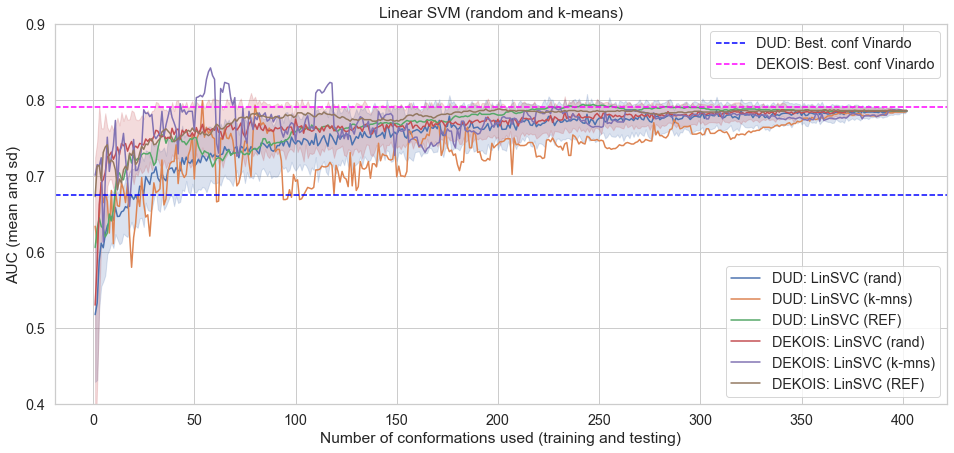

In [15]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'LinSVC (rand)': lSVC_rd_dict, 'LinSVC (k-mns)': lSVC_km_dict,
               'LinSVC (REF)': lSVC_rfe_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Linear SVM (random and k-means)')
plt.show()

## Radial Basis Function SVM
<div style='background-color: #F9E5AB; min-height: 10px'></div>

#### Random picking

In [16]:
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

for score_type in score_types:
    rbfSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, 
                            test_keys, n_reps = 30, score_type = score_type, interval = 2,
                  **hyparms)

#### K-means picking

In [17]:
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

for score_type in score_types:
    rbfSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k, score_type = score_type,
                  **hyparms)

#### Recursive Feature Elimination

In [18]:
%%time
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

# Hyperparameters for RFE
from sklearn.linear_model import LogisticRegression
rfe_model = LogisticRegression
rfe_model_hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')
file_sufix = '_RFE-LgRgL2_'

for score_type in score_types:
    rbfSVC_rfe_dict =  RFE_wrapper(ml_model, model_name, scores_dic, train_key, test_keys,
                             score_type = score_type, interval = 2,
                             # extra parameters for RFE
                             min_confs= 2, # Minimum required for REF
                             train_by_itself = False, model_for_RFE = rfe_model,
                             file_sufix = file_sufix, rfe_model_hyparms = rfe_model_hyparms,
                            # Main estimator hyperparameters
                             **hyparms)

CPU times: user 23min 19s, sys: 17min 22s, total: 40min 41s
Wall time: 10min 18s


<h4>Visualization: <span class="text-muted">Radial Basis Function SVM</span></h4>

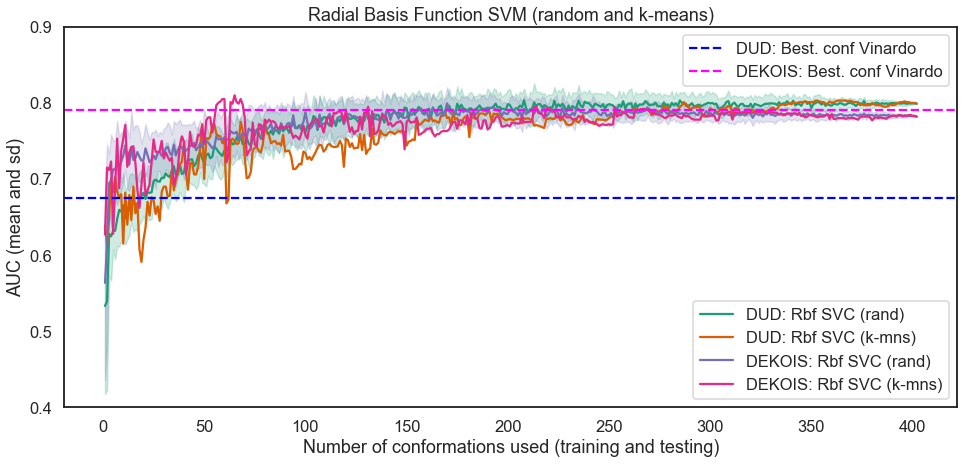

In [19]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'Rbf SVC (rand)': rbfSVC_rd_dict, 'Rbf SVC (k-mns)': rbfSVC_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Radial Basis Function SVM (random and k-means)')
plt.show()

## Logistic Regression
<div style='background-color: #F9E5AB; min-height: 10px'></div>

In [20]:
from sklearn.linear_model import LogisticRegression

#### Random picking

In [21]:
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, 
                                  train_key, test_keys, n_reps = 30, 
                                      score_type = score_type, interval = 2,
                                  **hyparms)

#### K-means picking

In [22]:
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                                   score_type = score_type,
                  **hyparms)

#### Recursive Feature Elimination

In [23]:
%%time
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_rfe_dict =  RFE_wrapper(ml_model, model_name, scores_dic, train_key, test_keys,
                              score_type = score_type, interval = 2,
                            **hyparms)

CPU times: user 22min 42s, sys: 16min 46s, total: 39min 28s
Wall time: 9min 57s


<h4>Visualization: <span class="text-muted">Logistic Regression</span></h4>

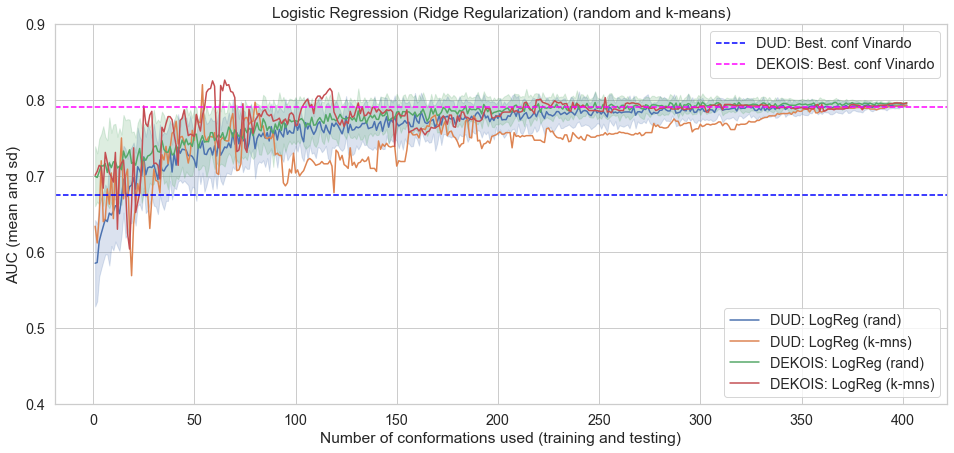

In [24]:
# Results
sns.set(context='notebook', style = 'whitegrid', font_scale = 1.3)
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'LogReg (rand)': logRG_rd_dict, 'LogReg (k-mns)': logRG_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Logistic Regression (Ridge Regularization) (random and k-means)')
plt.show()

## Decision Tree Classifier
<div style='background-color: #F9E5AB; min-height: 10px'></div>

In [25]:
from sklearn.tree import DecisionTreeClassifier

#### Random Picking

In [26]:
%%time
ml_model = DecisionTreeClassifier
model_name = 'Tree'
# hyperparameters
hyparms = dict(criterion = 'gini', max_depth = 2)

dTree_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, 
                                  train_key, test_keys, n_reps = 30,
                                  **hyparms)

CPU times: user 3.07 ms, sys: 0 ns, total: 3.07 ms
Wall time: 2.17 ms


#### K-means Picking

In [27]:
#%%time
ml_model = DecisionTreeClassifier
model_name = 'Tree'
# hyperparameters
hyparms = dict(criterion = 'gini', max_depth = 2)

dTree_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

#### Recursive Feature Elimination

In [28]:
%%time
ml_model = DecisionTreeClassifier
model_name = 'Tree'
# hyperparameters
hyparms = dict(criterion = 'gini', max_depth = 2)

dTree_ref_dict =  RFE_wrapper(ml_model, model_name, scores_dic, train_key, test_keys,
                            **hyparms)

CPU times: user 3.65 ms, sys: 0 ns, total: 3.65 ms
Wall time: 2.88 ms


<h4>Visualization: <span class="text-muted">Decision Tree Classifier</span></h4>

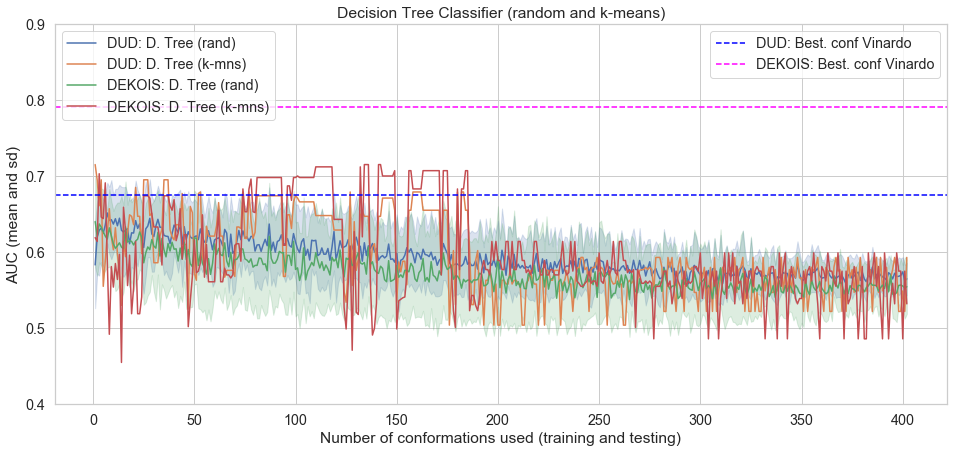

In [29]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'D. Tree (rand)': dTree_rd_dict, 'D. Tree (k-mns)': dTree_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, legend_position = 'upper left')
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Decision Tree Classifier (random and k-means)')
plt.show()

## Dummy Classifier
<div style='background-color: #F9E5AB; min-height: 10px'></div>

In [30]:
from sklearn.dummy import DummyClassifier

#### K-means picking

In [31]:
ml_model = DummyClassifier
model_name = 'DummyStf'
# hyperparameters
hyparms = dict(strategy = 'stratified')

DummyStf_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

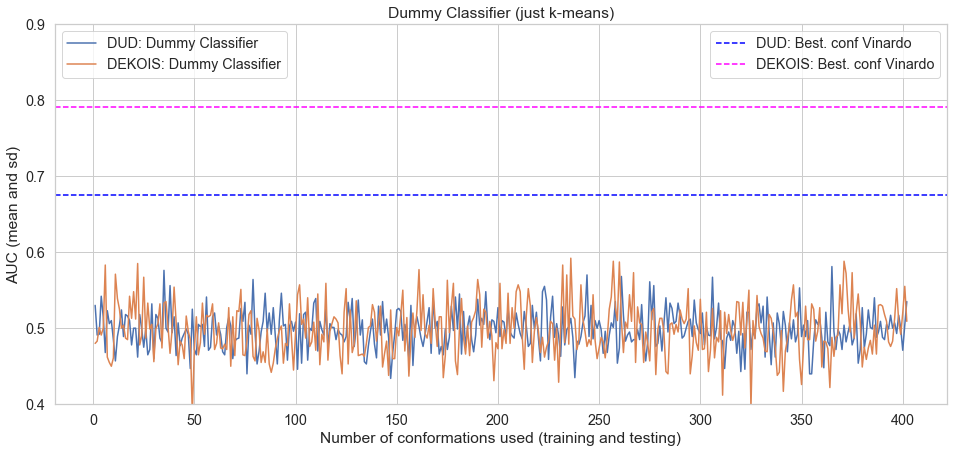

In [32]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'Dummy Classifier': DummyStf_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, legend_position = 'upper left')
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Dummy Classifier (just k-means)')
plt.show()

# DEKOIS TRAINING

In [33]:
N_REPS = 30 # Number of replicas to use in random picking
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1
# Output directory to save the results of each assay
output_dir = '../data/ml_evaluations/'

# Database to be used for training
train_key = 'DEKOIS'
# Dictionary of scores to be evaluated
scores_dic
# List of type of scores (docking score or ligand efficiency score)
score_types = ['Dk_lef', 'Dk_sc']
# List of datasets to be used as test
test_keys = ['DUD', 'CSAR']

### Linear SVM

In [34]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys, 
                  n_reps = 30, score_type = score_type,
                                     interval = 2,
                  **hyparms)

CPU times: user 1h 30min 22s, sys: 4min 16s, total: 1h 34min 39s
Wall time: 1h 34min 39s


In [35]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  score_type = score_type, 
                  **hyparms)

CPU times: user 6min 30s, sys: 19 s, total: 6min 49s
Wall time: 6min 49s


In [ ]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_rfe_dict, lSVC_rfe_FEATURES_ = RFE_wrapper(ml_model, model_name, 
                                               scores_dic, train_key, test_keys,
                                               score_type = score_type, interval = 2,
                                               **hyparms)

### Radial Baisis Function SVM

In [ ]:
%%time
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

for score_type in score_types:
    print(score_type)
    rbfSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, 
                                       test_keys, n_reps = 30, score_type = score_type,
                                       interval = 2,
                  **hyparms)

In [ ]:
%%time
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

for score_type in score_types:
    rbfSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k, score_type = score_type, 
                  **hyparms)

In [ ]:
%%time
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

# Hyperparameters for RFE
from sklearn.linear_model import LogisticRegression
rfe_model = LogisticRegression
rfe_model_hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')
file_sufix = '_RFE-LgRgL2_'

for score_type in score_types:
    rbfSVC_rfe_dict =  RFE_wrapper(ml_model, model_name, scores_dic, train_key, test_keys,
                             score_type = score_type, interval = 2,
                             # extra parameters for RFE
                             min_confs= 2, # Minimum required for REF
                             train_by_itself = False, model_for_RFE = rfe_model,
                             file_sufix = file_sufix, rfe_model_hyparms = rfe_model_hyparms,
                            # Main estimator hyperparameters
                             **hyparms)

### Logistic Regression

In [ ]:
%%time
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, 
                                  train_key, test_keys, n_reps = 30, interval = 2,
                                      score_type = score_type,
                                  **hyparms)

In [ ]:
%%time
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                                   score_type = score_type, 
                  **hyparms)

In [ ]:
%%time
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_rfe_dict =  RFE_wrapper(ml_model, model_name, scores_dic, train_key, test_keys,
                              score_type = score_type, interval = 2,
                            **hyparms)

# DUD TRAINING

In [ ]:
N_REPS = 30 # Number of replicas to use in random picking
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1
# Output directory to save the results of each assay
output_dir = '../data/ml_evaluations/'

# Database to be used for training
train_key = 'DUD'
# Dictionary of scores to be evaluated
scores_dic
# List of type of scores (docking score or ligand efficiency score)
score_types = ['Dk_lef', 'Dk_sc']
# List of datasets to be used as test
test_keys = ['DEKOIS', 'CSAR']

In [ ]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys, 
                  n_reps = 30, score_type = score_type,
                                     interval = 2,
                  **hyparms)

In [ ]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  score_type = score_type, 
                  **hyparms)

In [ ]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_rfe_dict, lSVC_rfe_FEATURES_ = RFE_wrapper(ml_model, model_name, 
                                               scores_dic, train_key, test_keys,
                                               score_type = score_type, interval = 2,
                                               **hyparms)

In [ ]:
%%time
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

for score_type in score_types:
    print(score_type)
    rbfSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, 
                                       test_keys, n_reps = 30, score_type = score_type,
                                       interval = 2,
                  **hyparms)

In [ ]:
%%time
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

for score_type in score_types:
    rbfSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k, score_type = score_type,
                  **hyparms)

In [ ]:
%%time
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

# Hyperparameters for RFE
from sklearn.linear_model import LogisticRegression
rfe_model = LogisticRegression
rfe_model_hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')
file_sufix = '_RFE-LgRgL2_'

for score_type in score_types:
    rbfSVC_rfe_dict =  RFE_wrapper(ml_model, model_name, scores_dic, train_key, test_keys,
                             score_type = score_type, interval = 2,
                             # extra parameters for RFE
                             min_confs= 2, # Minimum required for REF
                             train_by_itself = False, model_for_RFE = rfe_model,
                             file_sufix = file_sufix, rfe_model_hyparms = rfe_model_hyparms,
                            # Main estimator hyperparameters
                             **hyparms)

In [ ]:
%%time
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, 
                                  train_key, test_keys, n_reps = 30, interval = 2,
                                      score_type = score_type,
                                  **hyparms)

In [ ]:
%%time
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                                   score_type = score_type, 
                  **hyparms)

In [ ]:
%%time
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_rfe_dict =  RFE_wrapper(ml_model, model_name, scores_dic, train_key, test_keys,
                              score_type = score_type, interval = 2,
                            **hyparms)